In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd
import os

def read_banking_data():
    directory = "//".join([os.getcwd(), "data", "bank-marketing", "bank-additional-full.csv"])
    df = pd.read_csv(directory, sep=";")

    for column in df.columns:
        column_type = str(df[column].dtype)
        if "int" not in column_type and "float" not in column_type:
            df[column] = df[column].astype("category")

    cat_columns = df.select_dtypes(['category']).columns
    df_codified = df.copy()
    df_codified[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    return df, df_codified

In [28]:
from sklearn.decomposition import PCA
from node import remove_outliers
df, df_codified = read_banking_data()

pca = PCA(n_components=3)
reduced = pca.fit_transform(df_codified.loc[:,df_codified.columns!="y"])
df_reduced = pd.DataFrame(data = reduced, columns = ["x", "y", "z"])
df_reduced["label"] = df.y

suffled_df = df_reduced.sample(frac=1)
no_nodes = 8
sample_size =  int(df_reduced.shape[0]/no_nodes)

raw_node_data = [suffled_df.iloc[i*sample_size:(i+1) * sample_size] for i in range(no_nodes)]
node_data, models = remove_outliers(raw_node_data, return_models=True)

In [7]:
def pca_experiment(df):
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_[:3]))
    print(sum(pca.explained_variance_ratio_[:2]))

In [5]:
pca_experiment(df_codified.loc[:,df.columns!="y"])

[6.26788004e-01 3.30833615e-01 4.08471400e-02 1.01374092e-03
 1.92314271e-04 1.20238712e-04 6.96673197e-05 4.96416195e-05
 3.82617908e-05 1.80198272e-05 9.08848239e-06 7.24184225e-06
 4.84543109e-06 2.87288460e-06 1.92717561e-06 1.42287924e-06
 1.31112996e-06 2.47969899e-07 2.17159931e-07 1.81502791e-07]
0.998468759079651
0.9576216190451263


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_per_label(df):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    yes = df.loc[df.label == "yes"]
    no = df.loc[df.label == "no"]
    ax.scatter3D(yes.x, yes.y, yes.z, alpha=0.5)
    ax.scatter3D(no.x, no.y, no.z, alpha=0.5)
    plt.show()

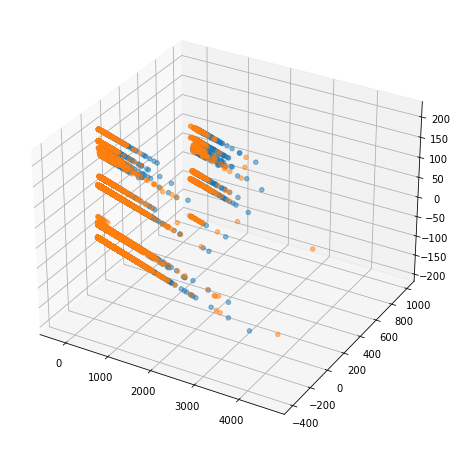

In [62]:
plot_per_label(df_reduced)

In [5]:
def plot_samples(node_data, per_label=False):
    if not per_label:
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
    for df in node_data:
        if per_label:
            plot_per_label(df)
        else:
            ax.scatter3D(df.x, df.y, df.z, alpha =0.3)
    if not per_label:
        plt.show()

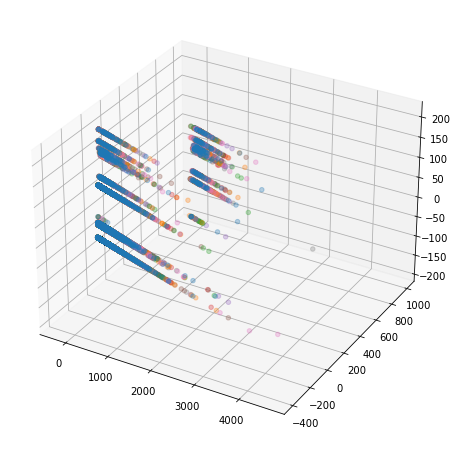

In [67]:
plot_samples(raw_node_data)

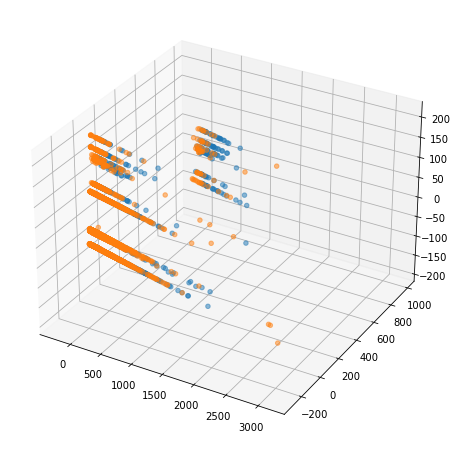

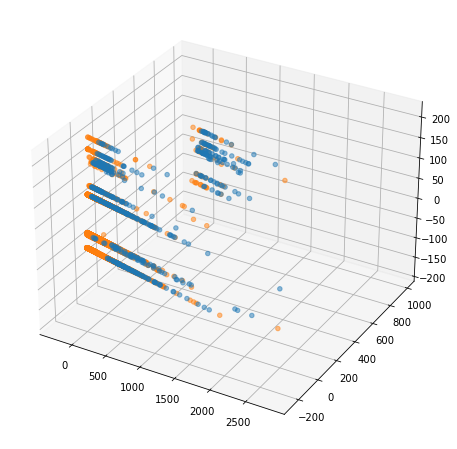

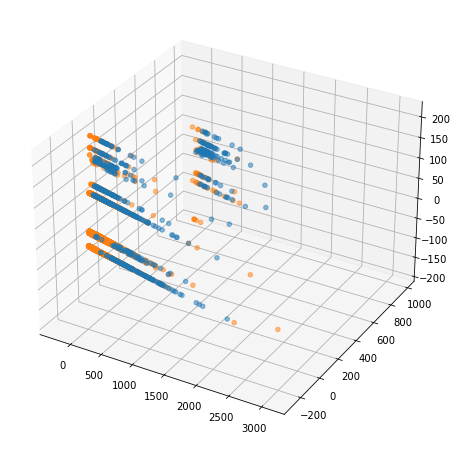

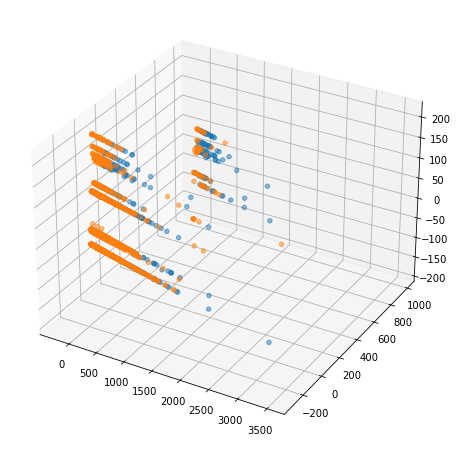

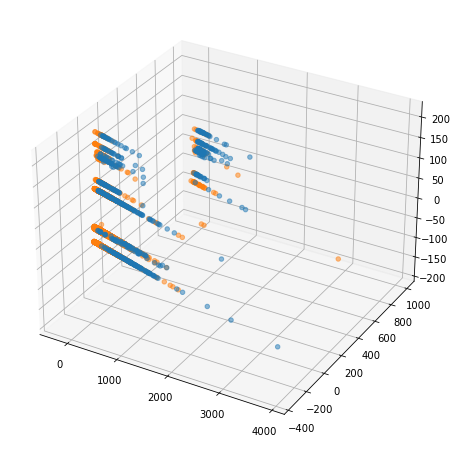

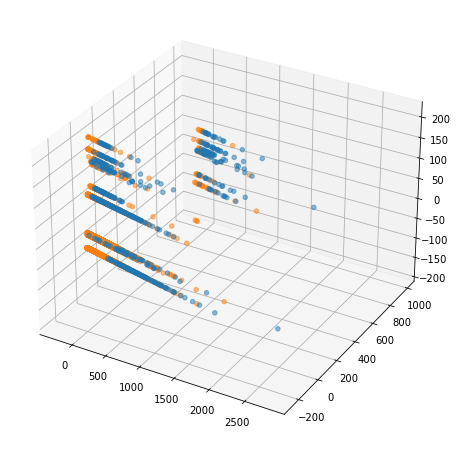

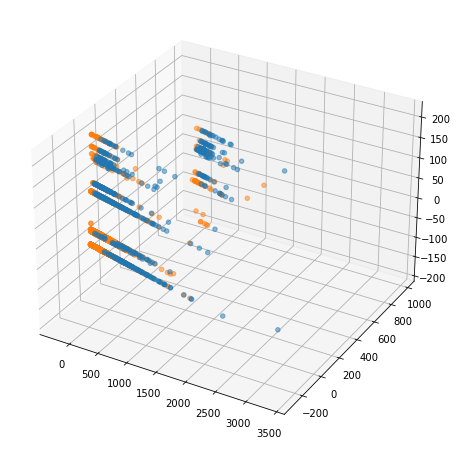

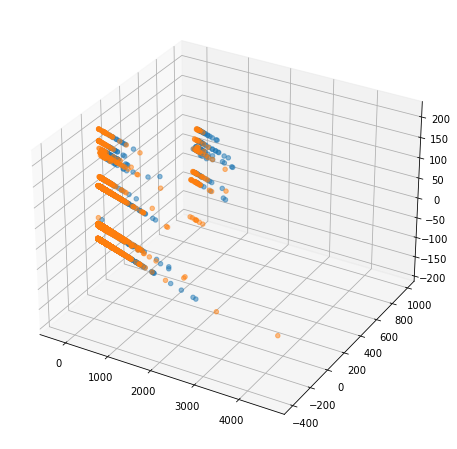

In [6]:
plot_samples(raw_node_data, per_label=True)

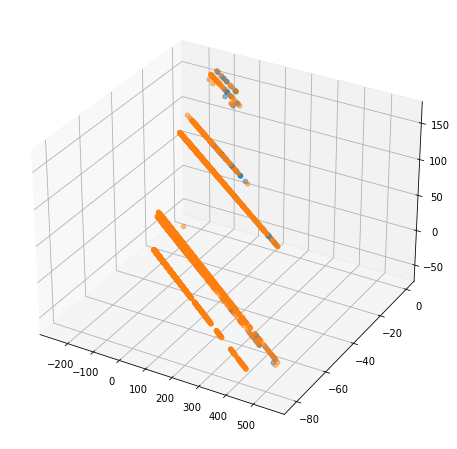

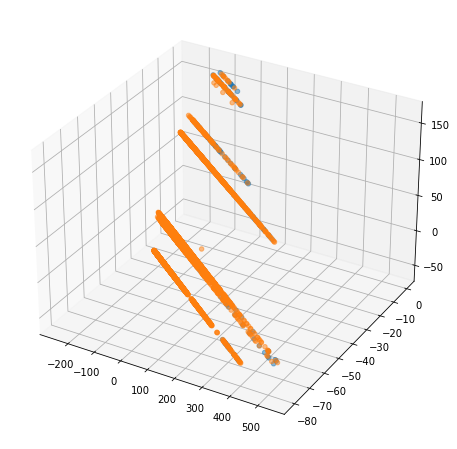

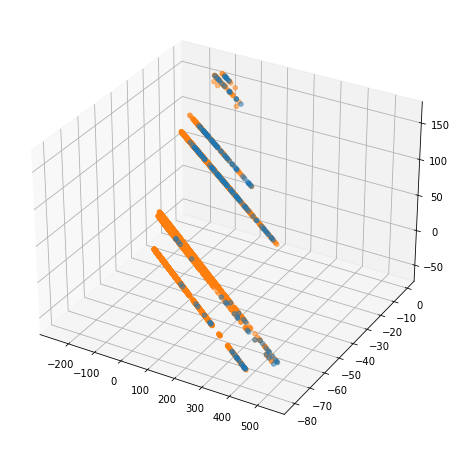

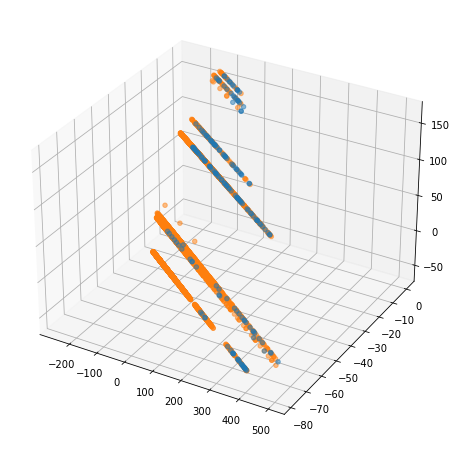

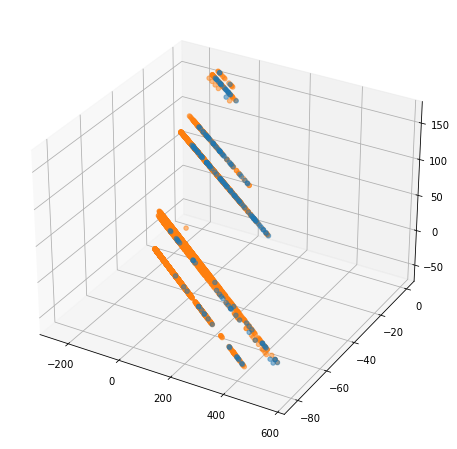

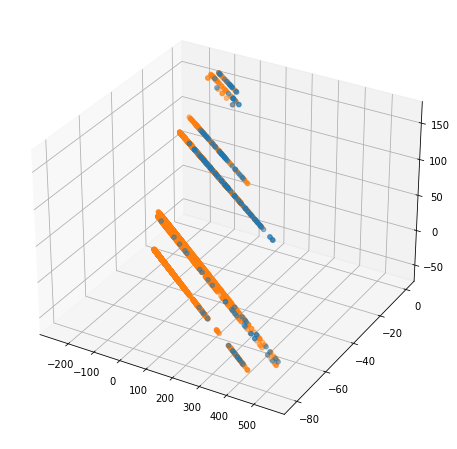

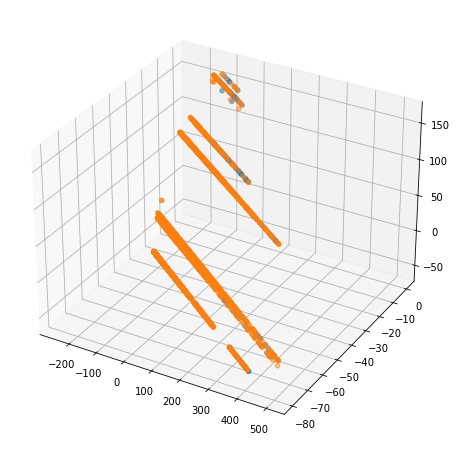

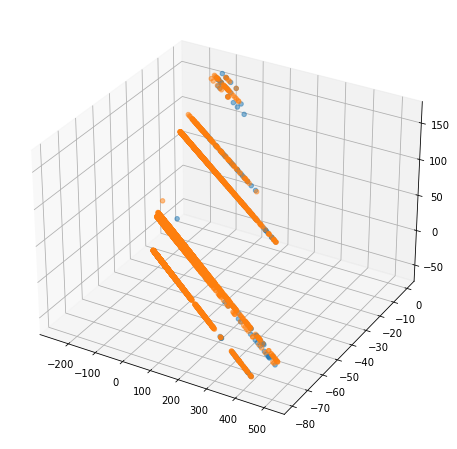

In [21]:
plot_samples(filtered_node_data, per_label=True)

In [8]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

In [24]:
from maximum_mean_discrepancy import get_tensor_samples
tensor_sample_size = min([df.shape[0] for df in node_data])
tensor_samples = get_tensor_samples(node_data, sample_size=tensor_sample_size)

In [26]:
import numpy as np
similar_nodes = ["pi4","pi5", "pi6", "pi7"]
other_nodes = ["pi2","pi3","pi8","pi9"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.2, 1, 5), "linear")

LINEAR 

+----------------+------------------+
|     Nodes      |   Similar MMD    |
+----------------+------------------+
| ('pi4', 'pi5') |   9.1826171875   |
| ('pi4', 'pi6') | 0.85345458984375 |
| ('pi4', 'pi7') | 3.25701904296875 |
| ('pi5', 'pi6') | 8.98443603515625 |
| ('pi5', 'pi7') | 2.34564208984375 |
| ('pi6', 'pi7') | 3.8035888671875  |
| ('pi3', 'pi4') | 0.72161865234375 |
| ('pi3', 'pi6') | 1.4727783203125  |
| ('pi3', 'pi7') |  1.907470703125  |
| ('pi8', 'pi4') |  0.73486328125   |
| ('pi8', 'pi6') | 1.19512939453125 |
| ('pi8', 'pi7') | 1.72332763671875 |
| ('pi9', 'pi6') | 2.3231201171875  |
| ('pi2', 'pi9') | 2.2261962890625  |
| ('pi3', 'pi8') | 0.49322509765625 |
+----------------+------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi2', 'pi4') |  8.05755615234375 |
| ('pi2', 'pi5') | 31.60430908203125 |
| ('pi2', 'pi6') |  7.4945068359375  |
| ('pi2', 'pi7') |  19.939331054687

In [27]:
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1000, 10000, 5), "rbf")

RBF 

+----------------+------------------------+
|     Nodes      |      Similar MMD       |
+----------------+------------------------+
| ('pi4', 'pi5') |  0.001126319169998169  |
| ('pi4', 'pi6') | 0.0004452615976333618  |
| ('pi4', 'pi7') | 0.0008452162146568298  |
| ('pi5', 'pi6') | 0.0007408410310745239  |
| ('pi5', 'pi7') | 0.00040040165185928345 |
| ('pi6', 'pi7') | 0.0006151869893074036  |
| ('pi2', 'pi4') | 0.0006158053874969482  |
| ('pi2', 'pi6') | 0.0004372149705886841  |
| ('pi2', 'pi7') | 0.0006382986903190613  |
| ('pi3', 'pi5') | 0.00041872262954711914 |
| ('pi3', 'pi6') | 0.0005778223276138306  |
| ('pi3', 'pi7') |  0.000456787645816803  |
| ('pi8', 'pi4') | 0.0004597380757331848  |
| ('pi8', 'pi6') | 0.00043860822916030884 |
| ('pi8', 'pi7') | 0.0005676448345184326  |
| ('pi9', 'pi6') | 0.0005848556756973267  |
| ('pi2', 'pi3') | 0.0003958195447921753  |
| ('pi3', 'pi8') | 0.0005370154976844788  |
+----------------+------------------------+
+----------------+--------

In [ ]:
"linear", 0.7
"rbf", 3250